# Frequentist models with PC1

**Importing required libraries**

In [374]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from thefuzz import process
from thefuzz import fuzz
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

## Change below parameters to perform the required analysis

1. Add the Poverty metric: 
        - Whole country:                               1
        - Urban:                                       2
        - Rural:                                       3
    

2. Data type:
        - RS +CDR:          1
        - RS only:          2
        - CDR only:         3
    

3. Model Type:

        - Random Rorest Regressor:                      1
        - Shallow Decision Tree Regressor:              2
        - Boosting Regressor:                           3


In [375]:
povery_metric = 2
data_type = 2
model_type = 1

**Importing the datasets**: 
Assigning the file paths of call detail records, remote sensing data, and principle component analysis data to mobile_path, satellite_path, and pca_path respectively

In [376]:
mobile_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/mobile_features.csv'
satellite_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/satellite_features.csv'
pca_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/pca_census.csv'
urban_rural = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/GND_urban_rural_classification.csv'

## Data Cleaning

In [377]:
#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc1"}).set_index('gnd_id')

#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

No of gnds with zero population: 37


### Data breakdown interms of urban rural classification

In [378]:
urb_rur = pd.read_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/GND_urban_rural_classification.csv')
print(urb_rur['urbanity'].value_counts())
urban_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Urban', 'gnd_id']
rural_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Rural', 'gnd_id']

if povery_metric == 1:
    pass
elif povery_metric == 2:
    data_raw = data_raw[data_raw.index.isin(urban_gnds)]
elif povery_metric == 3:
    data_raw = data_raw[data_raw.index.isin(rural_gnds)]

urbanity
Rural    12806
Urban     1216
Name: count, dtype: int64


## Data Processing

In [379]:
# Log transform skewed variables

data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    "pc1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])

In [380]:
if data_type == 1:
    data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

elif data_type == 2:    
    
    rs_only = data_unskewed[[
        "travel_time_major_cities_log",
        "population_count_worldpop_log",
        "population_count_ciesin_log",
        "population_density_log",
        "aridity_index",
        "evapotranspiration",
        "nighttime_lights",
        "elevation_log",
        "vegetation",
        "distance_roadways_motorway",
        "distance_roadways_trunk_log",
        "distance_roadways_primary_log",
        "distance_roadways_secondary_log",
        "distance_roadways_tertiary_log",
        "distance_waterways_log",
        "urban_rural_fb_log",
        "urban_rural_ciesin",
        "global_human_settlement_log",
        "protected_areas_log",
        "land_cover_woodland",
        "land_cover_grassland_log",
        "land_cover_cropland",
        "land_cover_wetland_log",
        "land_cover_bareland_log",
        "land_cover_urban",
        "land_cover_water_log",
        "pregnancies_log",
        "births_log",
        "precipitation",
        "temperature",

        "pc1"
    ]].copy()

    data_unskewed = rs_only.copy()

elif data_type == 3:
    
    cdr_only = data_unskewed[[
        "call_count",
            "avg_call_duration",
            "nighttime_call_count",
            "avg_nighttime_call_duration",
            "incoming_call_count",
            "avg_incoming_call_duration",
            "radius_of_gyration",
            "unique_tower_count",
            "spatial_entropy",
            "avg_call_count_per_contact",
            "avg_call_duration_per_contact",
            "contact_count",
            "social_entropy",
            "pc1" 
    ]].copy()

    data_unskewed = cdr_only.copy()

    

In [381]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

travel_time_major_cities_log       0
population_count_worldpop_log      0
population_count_ciesin_log        0
population_density_log             0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
elevation_log                      0
vegetation                         0
distance_roadways_motorway         0
distance_roadways_trunk_log        0
distance_roadways_primary_log      0
distance_roadways_secondary_log    0
distance_roadways_tertiary_log     0
distance_waterways_log             0
urban_rural_fb_log                 0
urban_rural_ciesin                 0
global_human_settlement_log        0
protected_areas_log                0
land_cover_woodland                0
land_cover_grassland_log           0
land_cover_cropland                0
land_cover_wetland_log             0
land_cover_bareland_log            0
land_cover_urban                   0
land_cover_water_log               0
pregnancies_log                    0
b

## correlation matrix

#### Removing highly correlated variables

In [382]:
if data_type == 1:

    correlation_matrix = data_unskewed.corr()

    # Highly Correlated Covariates
    high_correlation_threshold = 0.70
    high_correlation_pairs = np.where(np.abs(correlation_matrix) > high_correlation_threshold)

    covariates_to_drop = set()
    for i, j in zip(*high_correlation_pairs):
        if i != j and i not in covariates_to_drop and j not in covariates_to_drop:
            covariate_i = correlation_matrix.columns[i]
            covariate_j = correlation_matrix.columns[j]
            # Check if 'pc_1' is involved in the pair
            if 'pc_1' in (covariate_i, covariate_j):
                
                if covariate_i != 'pc_1':
                    covariates_to_drop.add(covariate_i)
                if covariate_j != 'pc_1':
                    covariates_to_drop.add(covariate_j)
            else:
                # Choose which covariate to drop based on your criteria
                # For example, drop the one with lower relevance
                # or keep the one with higher theoretical importance
                # or drop the one that contributes less to the analysis
                # Here, we simply drop the one with higher index
                if i > j:
                    covariates_to_drop.add(covariate_i)
                else:
                    covariates_to_drop.add(covariate_j)

    covariates_to_drop = {
        'avg_call_count_per_contact',
        'distance_roadways_tertiary_log',
        'global_human_settlement_log',
        'precipitation',
        'unique_tower_count',
        'urban_rural_fb_log'}

    data_unskewed = data_unskewed.drop(columns=covariates_to_drop)

    # Verify Multicollinearity Reduction (optional)
    #correlation_matrix_cleaned = df_cleaned.corr()

## Data stratification based on Province

In [383]:
'''
The province id is included in every gnd id's first digit 

ex: if gnd id starts with 23405....
    its corresponding province id is 2

Below data stratification is done as to represent 80 percent of gnds within a province

'''

province = data_unskewed.index.astype(str).str[0] 


X_train, X_test, y_train, y_test = train_test_split(data_unskewed.drop(columns=["pc1"]), data_unskewed["pc1"], stratify=province, test_size=0.2)

In [384]:
''' 
Normalize and remove highly correlated and near-zero variance variables (scaling the data to have a mean of 0 and a standard deviation of 1)
'''

if data_type == 0:

    scaler_train = StandardScaler()
    data_train_scaled = scaler_train.fit_transform(X_train)

    scaler_test = StandardScaler()
    data_test_scaled = scaler_test.fit_transform(X_test)

    scaler_full = StandardScaler()
    data_full_scaled = scaler_full.fit_transform(data_unskewed.drop(columns="pc1"))

    # Convert the scaled data back to a DataFrame
    data_full_scaled = pd.DataFrame(data_full_scaled, columns=data_unskewed.columns.drop("pc1"))
    data_full_scaled["pc1"] = data_unskewed["pc1"]

    data_train_scaled = pd.DataFrame(data_train_scaled, columns=X_train.columns)
    data_train_scaled.index = X_train.index


    data_test_scaled = pd.DataFrame(data_test_scaled, columns=X_test.columns)
    data_test_scaled.index = X_test.index

    #data_train_scaled = x train
    #data_test_scaled = x test



## Processing Sri Lanka shapefile

In [385]:
data_shapefile = gpd.read_file("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)
data_shapefile = data_shapefile.to_crs(epsg=3857)

#total data merge with the shapefile
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)
merged = merged.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#train set merge with the shapefile
merged_train = X_train.merge(data_shapefile, left_on=X_train.index, right_on='code_7', how='inner')
gdf_train = gpd.GeoDataFrame(merged_train, geometry='geometry', crs=data_shapefile.crs)
gdf_train = gdf_train.to_crs(epsg=3857)
merged_train = merged_train.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#test data merge with the shapefile
merged_test = X_test.merge(data_shapefile, left_on=X_test.index, right_on='code_7', how='inner')
gdf_test = gpd.GeoDataFrame(merged_test, geometry='geometry', crs=data_shapefile.crs)
gdf_test = gdf_test.to_crs(epsg=3857)
merged_test = merged_test.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

**The Sri Lankan map**: Red indicates gnds with population, while gray indicates the gnds with zero population

(np.float64(8854053.430712115),
 np.float64(9126918.94253964),
 np.float64(638018.8213061832),
 np.float64(1122278.6930524309))

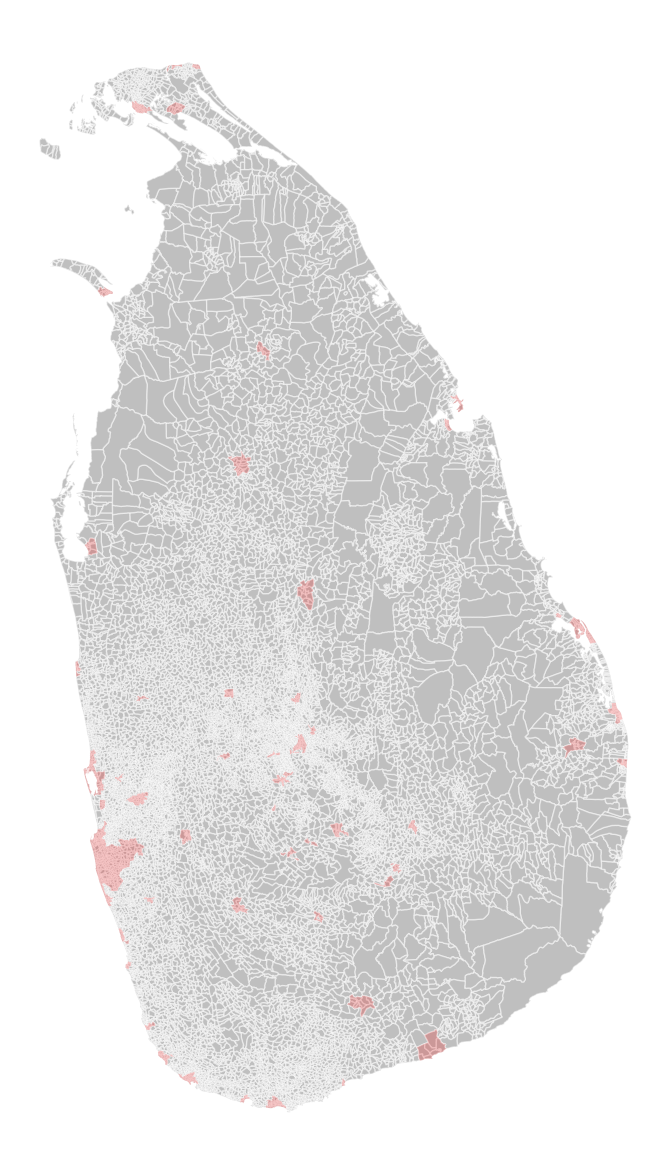

In [386]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

data_shapefile.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

ax.axis('off')

# Ground Truth Map

Data obtained from principle component analysis

Text(0.5, 1.0, 'Ground truth map')

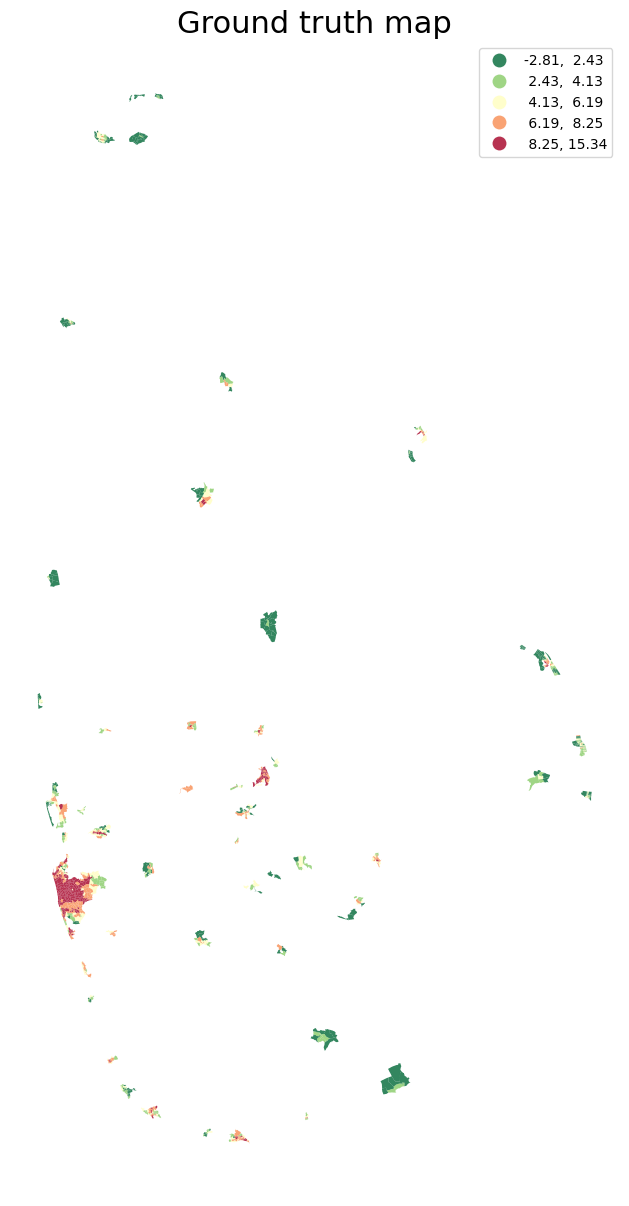

In [387]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pc1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('Ground truth map',fontsize=22)

## Modeling



### 1. **Random Forest Regressor**

    - 500 TREES
    - 1000 TREES
    - 2000 TREES

### 2. **Shallow Decision Tree Regressor**

    - 3 DEEP
    - 5 DEEP
    - 10 DEEP

### 3. **Boosting Regressor**

    - XGBoost

## Random Forest Regressor

In [367]:
def train_and_evaluate(n_estimators):
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Random Forest with {n_estimators} trees")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("-" * 40)

    return rf_regressor.predict(data_unskewed.drop(columns="pc1"))

In [368]:
# 500, 1000, and 2000 trees
merged['pred_ground_truth'] = train_and_evaluate(1000)

Random Forest with 1000 trees
Mean Squared Error: 2.8222001467571216
R-squared: 0.7564072846665192
----------------------------------------


## Shallow Decision Tree Regressor

In [142]:
def train_and_evaluate(max_depth):
    dt_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt_regressor.fit(X_train, y_train)
    y_pred = dt_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Decision Tree with max depth {max_depth}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("-" * 40)

    return dt_regressor.predict(data_unskewed.drop(columns="pc1"))

In [143]:
# max depths 3, 5, and 10
merged['pred_ground_truth'] = train_and_evaluate(10)

Decision Tree with max depth 10
Mean Squared Error: 3.313997606562122
R-squared: 0.6885767877803723
----------------------------------------


## Boosting Regressor

In [388]:
xgb_regressor = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

merged['pred_ground_truth'] = xgb_regressor.predict(data_unskewed.drop(columns="pc1"))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regressor")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


XGBoost Regressor
Mean Squared Error: 2.7374802488987036
R-squared: 0.7230464127936529


## Results visualization 

In [849]:
if model_type == 1:
    merged['pred_ground_truth'] = model_SDEM.predy.flatten()

elif model_type== 2:
    merged['pred_ground_truth'] = sem_model.predy.flatten()

elif model_type== 3:
    merged['pred_ground_truth'] = slx_model.predy.flatten()    

Text(0.5, 1.0, '')

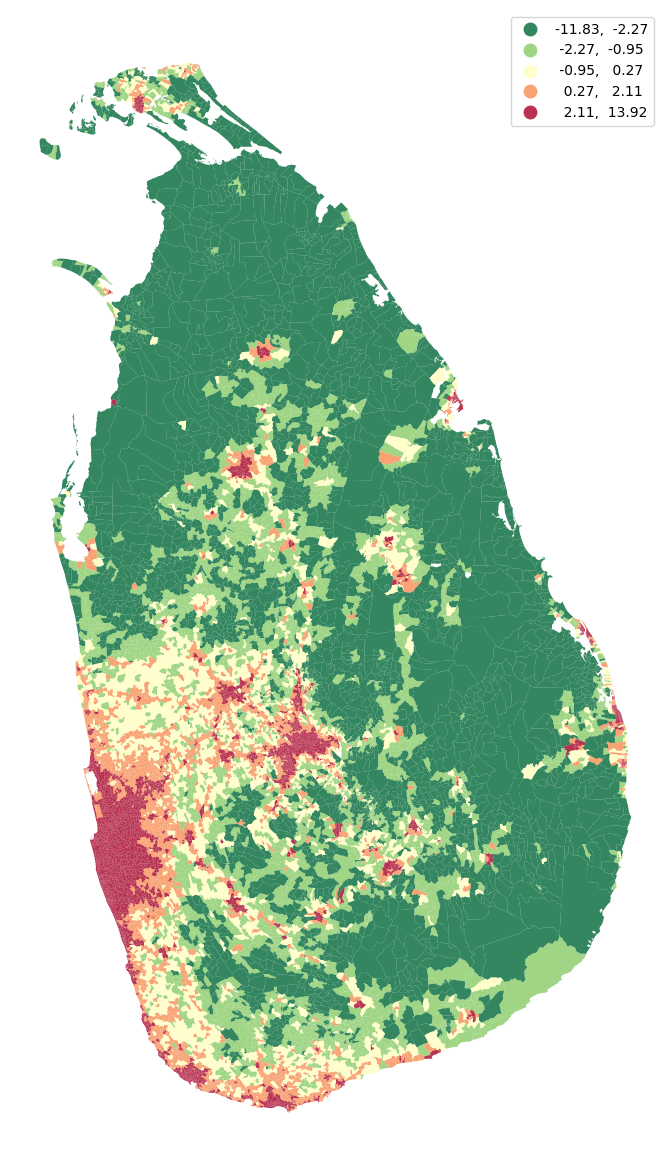

In [62]:
#merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.code_7, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pred_ground_truth',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('',fontsize=22)

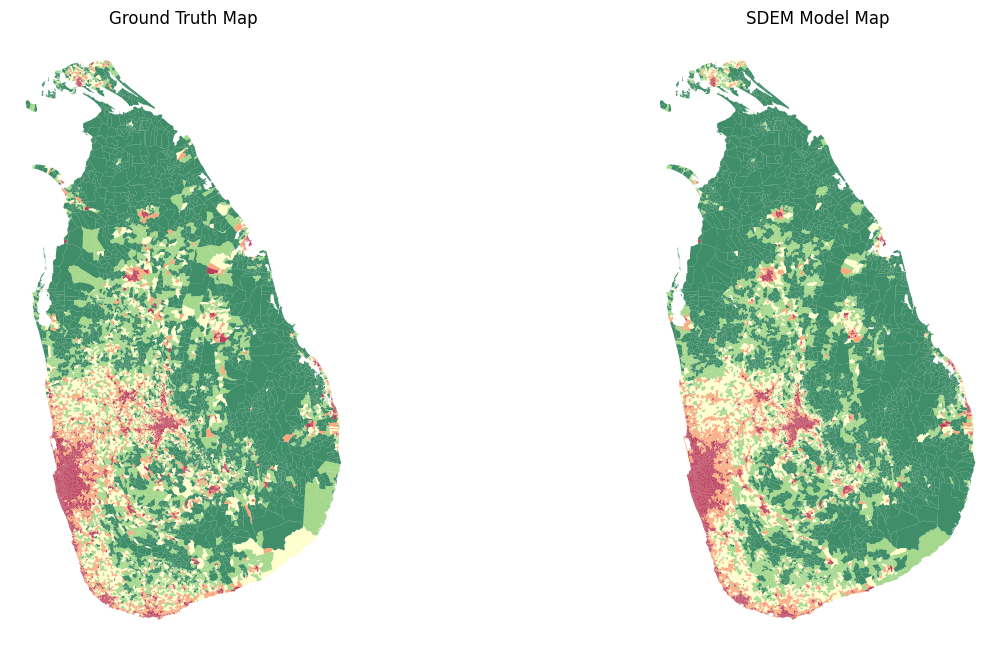

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")


gdf.plot(ax=ax[1],
         column='pred_ground_truth', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

## Evaluating model performance 

### 1. Predicting poorest 100, 500, 1000, 3000 GNDS

In [389]:
def prediction_performance(A, B):
    
    B_set = set(B)
    count = 0
    
    for element in A:
        if element in B_set:
            count += 1
            
    return count

In [390]:
for i in (100, 500, 1000, 3000):
    merged = merged.sort_values('pc1')
    pc_top = merged.iloc[:i]
    index_values_pc = pc_top.index.values

    merged = merged.sort_values('pred_ground_truth')

    df_top = merged.iloc[:i]   
    index_values_top = df_top.index.values

    print(f'Predicting poorest {i} Gnds: ',(prediction_performance(index_values_pc, index_values_top) / i )*100)


Predicting poorest 100 Gnds:  92.0
Predicting poorest 500 Gnds:  94.6
Predicting poorest 1000 Gnds:  98.4
Predicting poorest 3000 Gnds:  40.53333333333333


### 2. Predicting poorest 25, 50, 100 DSDs

In [391]:
# Read DSD-level poverty data
dsd_poverty = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/dsd-poverty.csv")
#Read census features 
census = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/census_features.csv", usecols=["gnd_id", "age_total"])
census = census.rename(columns={"age_total": "pop"})

data_b2 = merged[['code_7', 'pc1', 'pred_ground_truth']].copy()

# Merge predicted values with the census data

merged2 = data_b2.merge(census, left_on=data_b2.code_7, right_on='gnd_id', how='inner')

# Merge with data_shapefile

gnd2dsd_df = data_shapefile.drop(columns="geometry")
merged2 = merged2.merge(gnd2dsd_df, left_on=merged.code_7, right_on=gnd2dsd_df.index, how='inner')

#Taking the Gnd level predicted data to the DSD level

dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["pred_ground_truth"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")

# Rename the misspelled columns using FizzBuzz

dsd_grouped["dsd_name"] = dsd_grouped["dsd_name"].apply(
  lambda x: process.extractOne(x, dsd_poverty["dsd_name"], scorer=fuzz.partial_ratio)[0]
)

dsd_final = dsd_grouped.merge(dsd_poverty, on='dsd_name', how='inner')

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_42216/2107854258.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["pred_ground_truth"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")


In [392]:
for x in (25, 50, 100):

    predicted_list = dsd_grouped.sort_values(by="fit_wted", ascending=False)
    predicted_list = predicted_list.head(x).copy()
    predicted_list = predicted_list.dsd_name.to_list()


    hc_list = dsd_poverty.sort_values(by="headcount_index", ascending=True)
    hc_list = hc_list.head(x).copy()
    hc_list = hc_list.dsd_name.to_list()

    series_a = pd.Series(predicted_list)
    series_b = pd.Series(hc_list)


    percentage = (series_b.isin(predicted_list).sum() / len(series_b)) * 100

    print(f"The percentage of predicting poorest {x} DSDs: {percentage}%")

The percentage of predicting poorest 25 DSDs: 60.0%
The percentage of predicting poorest 50 DSDs: 64.0%
The percentage of predicting poorest 100 DSDs: 47.0%
